Описание оставил для напоминалок
<p align="center"><img src="https://sun9-47.userapi.com/impg/9O7QpxwOQuuHaN-lkMCNGtWlN25KzZ7osYsfSg/9XZLRedMvvk.jpg?size=549x720&quality=95&sign=5848c8d2ee2bac7f29caf35e2f04324e&type=album" width=300/></p>



Тем не менее, не время расслабляться! На этот раз мы не будем рассказывать вам новый материал - лишь дадим пару напутствий и пожелаем успехов и сил!

В этот раз вам предлагается разработать модель предсказания цены домов по набору данных Boston Houses Pricing. Мы его уже немного пощупали в прошлой практике, но в этой вам предстоит сделать всё самостоятельно и на полных данных!

Что надо будет сделать:
- загрузить данные;
- посмотреть и размер, и примеры данных;
- проверить количество пропусков в данных;
    - убедиться, что пропусков в данных нет и можно строить **baseline**;
- разделить данные на train и test;
    - Делаем это один раз! Все дальнейшие модификации и улучшения должны делаться на основе единственного разделения!
    - И не забудьте зафиксировать сид! Переменную `RANDOM_SEED` мы даём ниже;
- создать baseline модель, получить метрики на тестовой выборке;
- проанализировать данные, подготовить план по очистке и предобработке данных;
- создать функцию очистки;
- произвести очистку train и test выборок -> обучаем модель с очищенными данными;
    - Снимаем метрики и так мы оцениваем влияние очистки данных на обучение;
- создать класс предобработки данных;
- сделать предобработку очищенных данных -> обучаем модель;
    - Снимаем метрики и так мы оцениваем влияние предобработки данных на обучение;

А дальше можете пофантазировать, почитать интернет и посмотреть, как улучшить метрики! 

**Ваша цель - достигнуть наилучших показателей!**

Вот вам пара идей по интересной организации предобработке:
- по признаку `CRIM` создать признак `is_CRIM`, который будет равен 1, если `CRIM` не равен 0 и 0, если `CRIM` равен нулю;
- сделать обучение модели [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html), посмотреть, какие признаки имеют веса близкие к 0 и убрать их из обучения как незначимые;
- оставить только признаки с высокой корреляцией с целевой переменной;
- посмотреть, какие переменные коррелирцют между собой и оставить только единственные из пар коррелирующих;
- посмотреть, в каких примерах данных модель ошибается сильнее всего (отсортировать записи из теста по величине ошибки) и проанализировать, есть ли какая-то зависимость или шум;
- комбинировать разные подходы в зависимости от того, помогает это предсказаниям или нет.

In [1]:
# Зафиксируем состояние случайных чисел
import numpy as np
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
import seaborn as sns
import matplotlib.pyplot as plt


RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

TEXT_COLOR = "black"

plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["text.color"] = TEXT_COLOR
plt.rcParams["font.size"] = 14
plt.rcParams["lines.markersize"] = 15
plt.rcParams["axes.labelcolor"] = TEXT_COLOR
plt.rcParams["xtick.color"] = TEXT_COLOR
plt.rcParams["ytick.color"] = TEXT_COLOR

sns.set_style("darkgrid")


In [2]:
df = pd.read_csv("boston.csv")
df = df[df['MEDV'] < 44] #подчистка данных выбросов, о ввыбросах узнал дальше в ноутбуке, вставил сюда т.к. так как почему то значения ошибок становятся еще меньше чем просто там юзнуть функцию
df.shape

(482, 14)

In [3]:
#смотрим на сами данные
df.head(20)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311.0,15.2,386.71,17.10,18.9


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 482 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     482 non-null    float64
 1   ZN       482 non-null    float64
 2   INDUS    482 non-null    float64
 3   CHAS     482 non-null    int64  
 4   NOX      482 non-null    float64
 5   RM       482 non-null    float64
 6   AGE      482 non-null    float64
 7   DIS      482 non-null    float64
 8   RAD      482 non-null    int64  
 9   TAX      482 non-null    float64
 10  PTRATIO  482 non-null    float64
 11  B        482 non-null    float64
 12  LSTAT    482 non-null    float64
 13  MEDV     482 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 56.5 KB


In [5]:
#смотрим на общие пропуски в данных
df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

In [6]:
# оставляем все кроме МЕДВ
X = df.drop('MEDV', axis=1) 
y = df['MEDV']  

In [7]:
data = pd.concat([X, y], axis=1)
correlation_matrix = data.corr()
correlation_matrix

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000000,-0.198888,0.405493,-0.063390,0.419488,-0.215446,0.353686,-0.382653,0.626574,0.582647,0.284125,-0.383264,0.460234,-0.471266
ZN,-0.198888,1.000000,-0.528359,-0.056321,-0.511133,0.306299,-0.566561,0.680191,-0.305881,-0.297069,-0.373218,0.175802,-0.420337,0.405853
INDUS,0.405493,-0.528359,1.000000,0.042838,0.765623,-0.397759,0.640169,-0.714503,0.594515,0.713468,0.374276,-0.361643,0.629589,-0.606352
CHAS,-0.063390,-0.056321,0.042838,1.000000,0.093571,0.039697,0.076871,-0.084354,-0.030605,-0.062861,-0.111334,0.041680,0.000551,0.067718
NOX,0.419488,-0.511133,0.765623,0.093571,1.000000,-0.320977,0.727439,-0.768145,0.611959,0.666075,0.181096,-0.382676,0.610490,-0.544073
RM,-0.215446,0.306299,-0.397759,0.039697,-0.320977,1.000000,-0.271667,0.258411,-0.189533,-0.262472,-0.255426,0.112873,-0.599738,0.640861
AGE,0.353686,-0.566561,0.640169,0.076871,0.727439,-0.271667,1.000000,-0.745009,0.452358,0.499556,0.267931,-0.279097,0.640422,-0.517492
DIS,-0.382653,0.680191,-0.714503,-0.084354,-0.768145,0.258411,-0.745009,1.000000,-0.491708,-0.533355,-0.248019,0.299674,-0.540989,0.396733
RAD,0.626574,-0.305881,0.594515,-0.030605,0.611959,-0.189533,0.452358,-0.491708,1.000000,0.909987,0.454233,-0.450460,0.508856,-0.498168
TAX,0.582647,-0.297069,0.713468,-0.062861,0.666075,-0.262472,0.499556,-0.533355,0.909987,1.000000,0.442329,-0.447111,0.559207,-0.580928


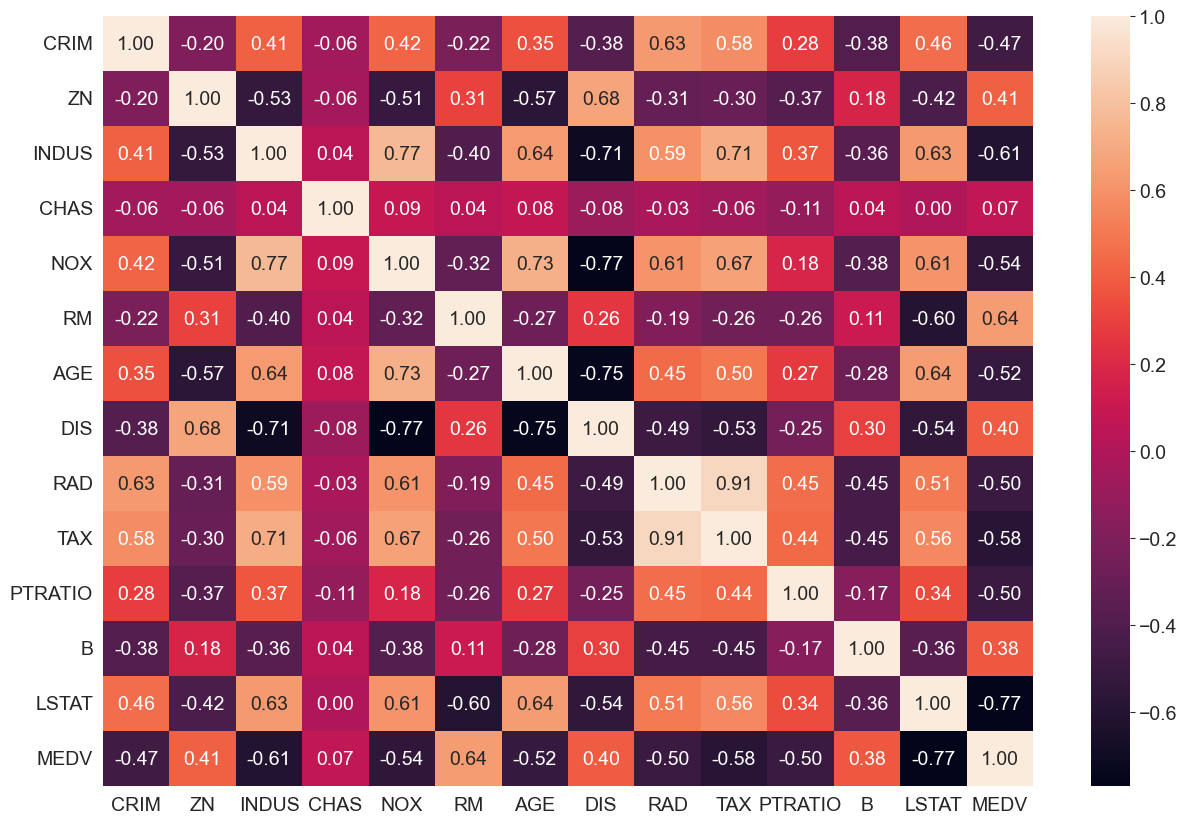

In [8]:
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.show()

In [9]:
# Посмотрим на корреляцию всех признаков с целевой переменной medv
correlation_with_target = correlation_matrix['MEDV'].sort_values(ascending=False)
correlation_with_target

MEDV       1.000000
RM         0.640861
ZN         0.405853
DIS        0.396733
B          0.382773
CHAS       0.067718
CRIM      -0.471266
RAD       -0.498168
PTRATIO   -0.500009
AGE       -0.517492
NOX       -0.544073
TAX       -0.580928
INDUS     -0.606352
LSTAT     -0.770445
Name: MEDV, dtype: float64

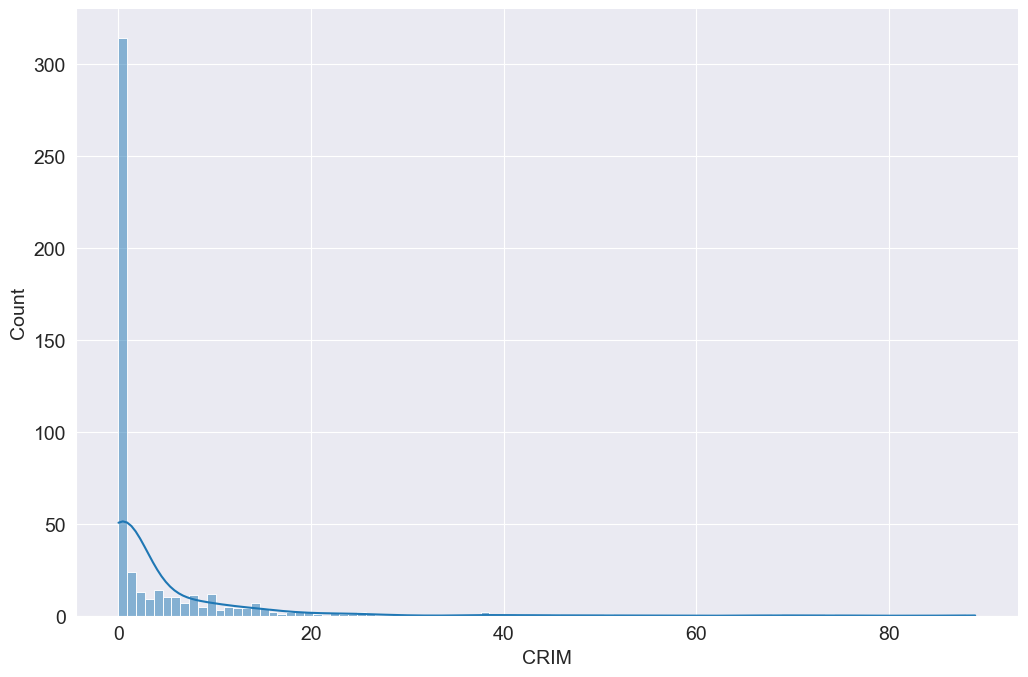

In [10]:
#что то в параметре CRIM распределение не очень хорошее, сильное смещение влево
sns.displot(df["CRIM"], kde=True, height=7, aspect=1.5)
plt.show()

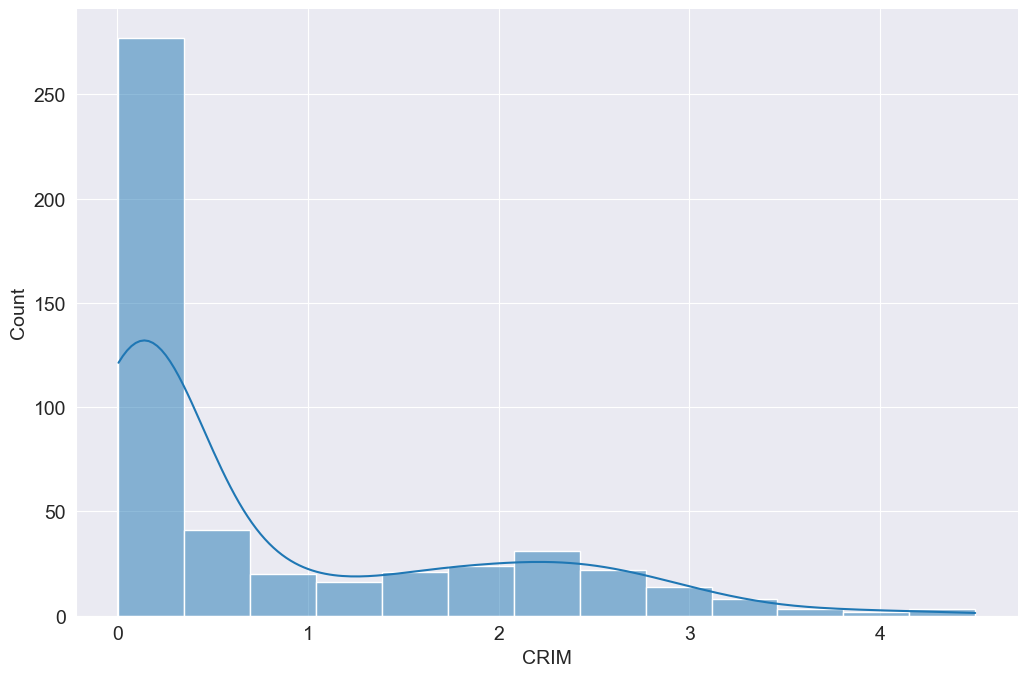

In [11]:
#применим логарифмическое выранивание для улучшения ситуации

CRIM_log_col = np.log1p(df["CRIM"])
sns.displot(CRIM_log_col, kde=True, height=7, aspect=1.5)
plt.show()

In [12]:
#Создаем признак `is_CRIM`, который будет равен 1, если `CRIM` не равен 0 и 0, если `CRIM` равен нулю (у нас же нет идеально нуля ни в одной строчке? Везде в итоге будут единицы)
X['is_CRIM'] = (X['CRIM'] != 0).astype(int)
X

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,is_CRIM
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,1
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,1
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,1
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,1
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,1
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,1
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,1
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,1


In [13]:
xx = X.corr()
xx

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,is_CRIM
CRIM,1.000000,-0.198888,0.405493,-0.063390,0.419488,-0.215446,0.353686,-0.382653,0.626574,0.582647,0.284125,-0.383264,0.460234,NaN
ZN,-0.198888,1.000000,-0.528359,-0.056321,-0.511133,0.306299,-0.566561,0.680191,-0.305881,-0.297069,-0.373218,0.175802,-0.420337,NaN
INDUS,0.405493,-0.528359,1.000000,0.042838,0.765623,-0.397759,0.640169,-0.714503,0.594515,0.713468,0.374276,-0.361643,0.629589,NaN
CHAS,-0.063390,-0.056321,0.042838,1.000000,0.093571,0.039697,0.076871,-0.084354,-0.030605,-0.062861,-0.111334,0.041680,0.000551,NaN
NOX,0.419488,-0.511133,0.765623,0.093571,1.000000,-0.320977,0.727439,-0.768145,0.611959,0.666075,0.181096,-0.382676,0.610490,NaN
RM,-0.215446,0.306299,-0.397759,0.039697,-0.320977,1.000000,-0.271667,0.258411,-0.189533,-0.262472,-0.255426,0.112873,-0.599738,NaN
AGE,0.353686,-0.566561,0.640169,0.076871,0.727439,-0.271667,1.000000,-0.745009,0.452358,0.499556,0.267931,-0.279097,0.640422,NaN
DIS,-0.382653,0.680191,-0.714503,-0.084354,-0.768145,0.258411,-0.745009,1.000000,-0.491708,-0.533355,-0.248019,0.299674,-0.540989,NaN
RAD,0.626574,-0.305881,0.594515,-0.030605,0.611959,-0.189533,0.452358,-0.491708,1.000000,0.909987,0.454233,-0.450460,0.508856,NaN
TAX,0.582647,-0.297069,0.713468,-0.062861,0.666075,-0.262472,0.499556,-0.533355,0.909987,1.000000,0.442329,-0.447111,0.559207,NaN


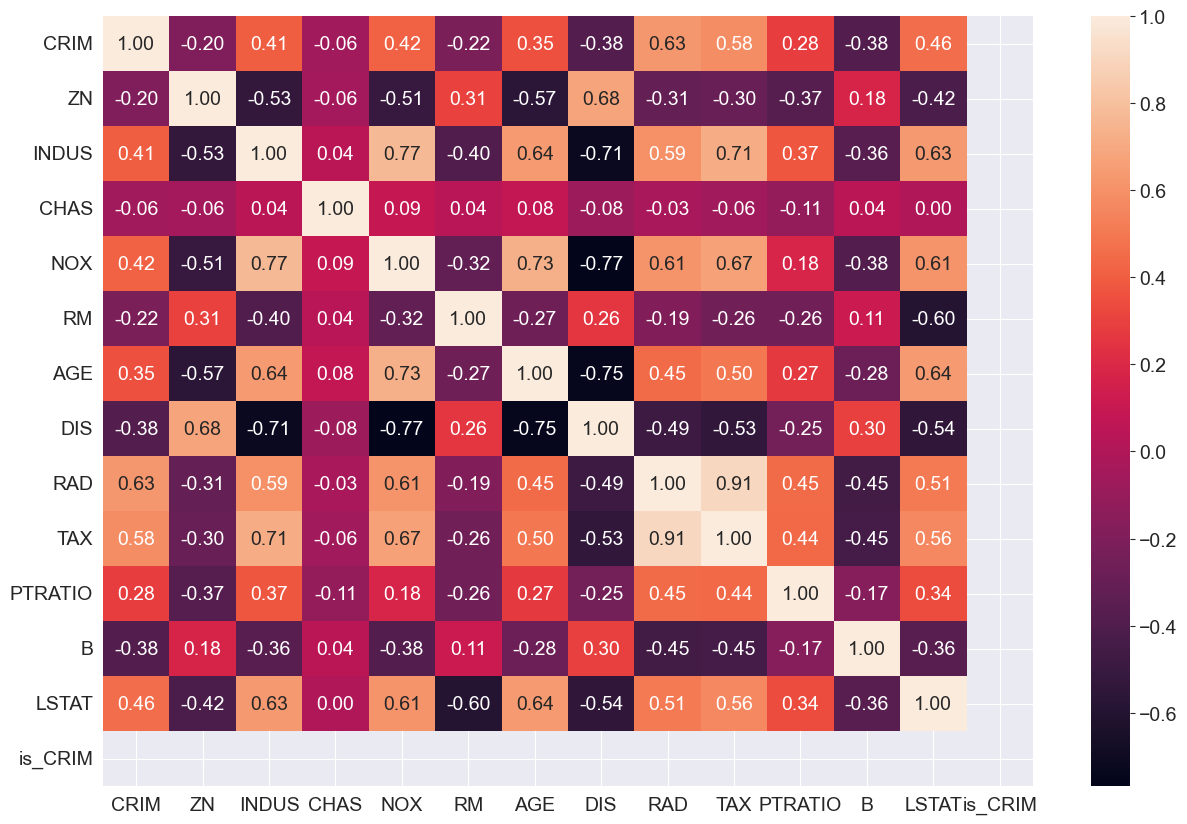

In [14]:
sns.heatmap(xx, annot=True, fmt=".2f")
plt.show()

Оставляем только высокую корреляцию (до подчистки данных - я выбрал 0,45, т.к. выше уже почти ничего нет(кроме РМ и лстат, которые были в 13 ноутбуке)) с целевой переменной

После подчистки данных в самом начале выбрал уже 0,6

In [15]:

high_correlation_features = correlation_with_target[correlation_with_target.abs() > 0.6].index.tolist()

# Убираем МЕДВ
high_correlation_features.remove('MEDV')

# в Х оставляем только признаки с высокой корреляцией 
X_filtered = X[high_correlation_features]
X_filtered

,RM,INDUS,LSTAT
0,6.575,2.31,4.98
1,6.421,7.07,9.14
2,7.185,7.07,4.03
3,6.998,2.18,2.94
4,7.147,2.18,5.33
...,...,...,...
501,6.593,11.93,9.67
502,6.120,11.93,9.08
503,6.976,11.93,5.64
504,6.794,11.93,6.48


In [16]:
xxx=X_filtered.corr()
xxx

,RM,INDUS,LSTAT
RM,1.000000,-0.397759,-0.599738
INDUS,-0.397759,1.000000,0.629589
LSTAT,-0.599738,0.629589,1.000000


In [17]:
#воспользуемся готовой функцией sklearn, чтобы изначально разделить наши данные:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=.3, random_state=RANDOM_SEED)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((337, 3), (145, 3), (337,), (145,))

In [18]:
#Создаем baseline модель и далее получаем метрики н аней
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

LinearRegression()

In [19]:
# предсказание на тестовой выборке
y_pred = reg_model.predict(X_test)

In [20]:
#тут я посчитал метрики ошибки
mae_baseline = mean_absolute_error(y_test, y_pred)
mse_baseline = mean_squared_error(y_test, y_pred)

print(f"mae: {mae_baseline}")
print(f"mse: {mse_baseline}")

mae: 3.457388203609757
mse: 19.159000421442716


Для справки до очистки в самом начале когда я загрузил данные с датасета - MSE было 29,8; После очистки стало 19,15

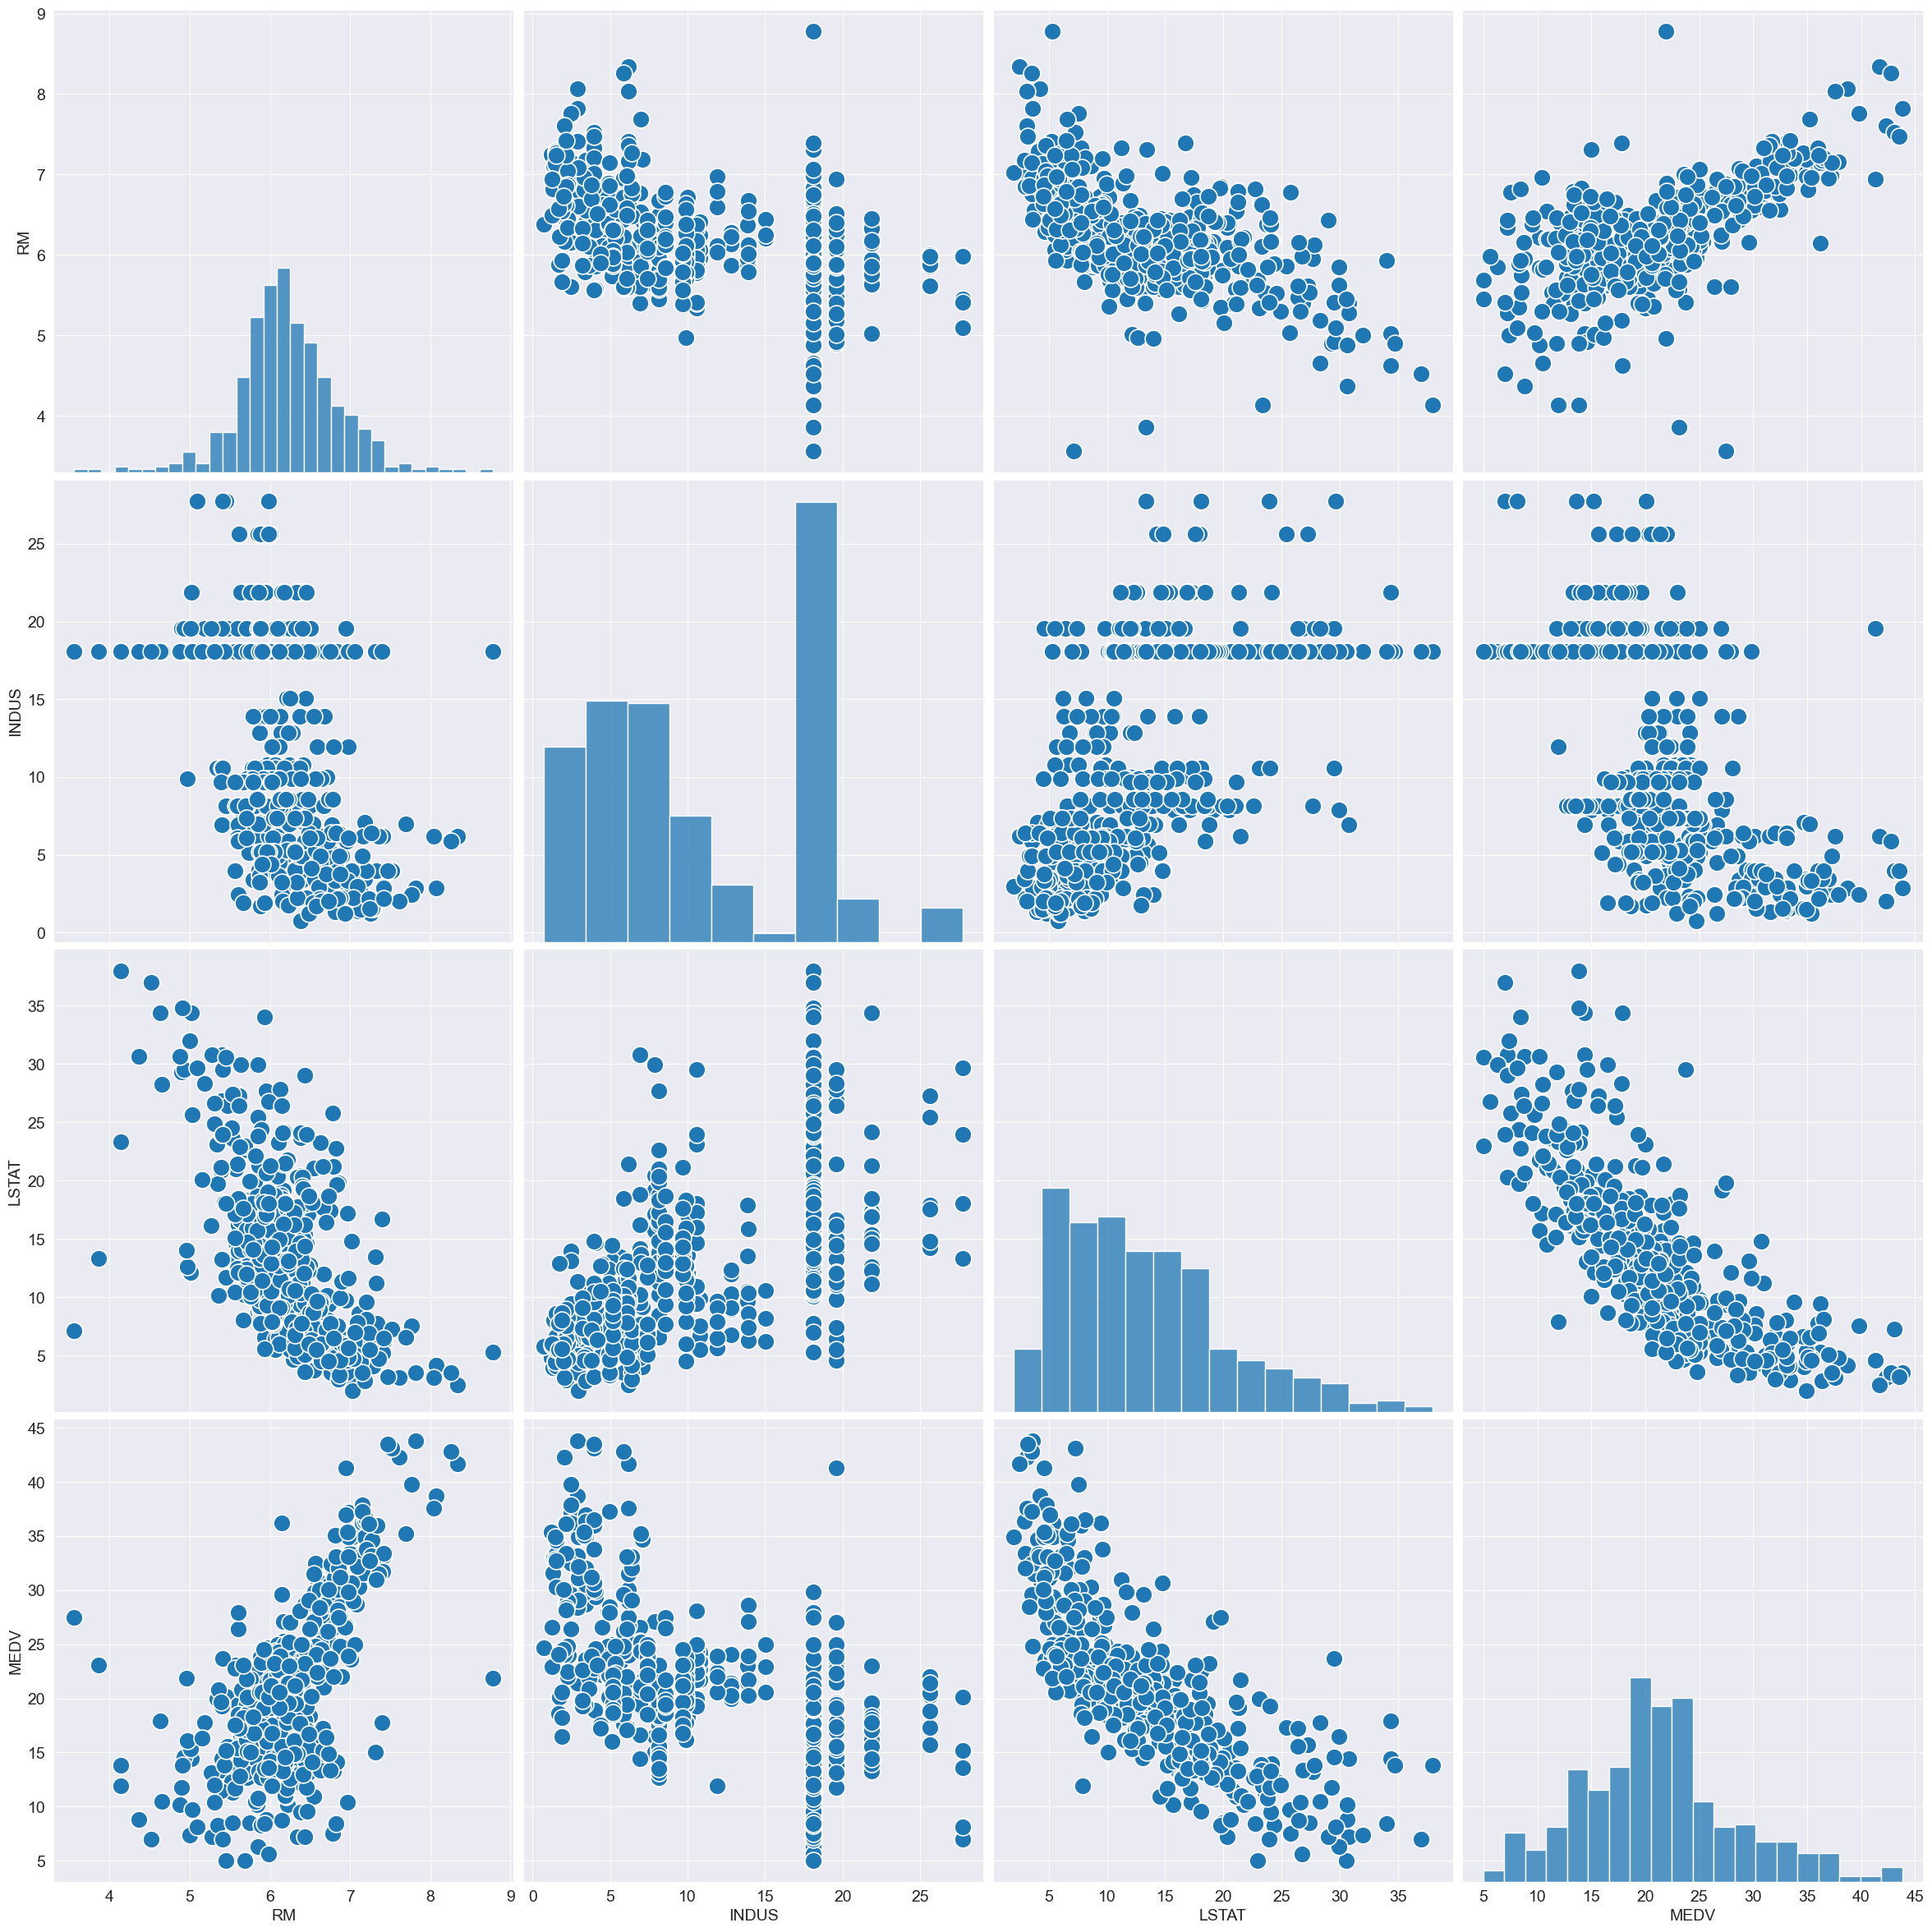

In [21]:
features =['RM', 'INDUS',	'LSTAT', 'MEDV'] #про именно эти параметры узнал чуть чуть дальше когда убрал метрики со слишком маленькими весами
sns.pairplot(df[features], diag_kind="auto", height=6)
plt.show()

In [22]:
#Делаем лассо
lasso = Lasso(alpha=0.1, random_state=RANDOM_SEED)
lasso.fit(X_train, y_train)
feature_importances = pd.Series(lasso.coef_, index=X_train.columns)

# оставляем признаки которые больше 0,2 (сделал 0,2 т.к. когда кодил то переиодически при меньшем значении вылезали ошибки)
important_features = feature_importances[abs(feature_importances) >= 0.2].index.tolist()
print("important_features:", important_features)


important_features: ['RM', 'INDUS', 'LSTAT']


In [23]:
from sklearn.preprocessing import MinMaxScaler

#предобработка с очсиктйо, масштабированием
class DataPreprocessing():
    def __init__(self):
        self.scaler = self.scaler = MinMaxScaler()
    
    def clean_data(self, X, y):
        df = pd.concat([X, y], axis=1)
        
        outliers_mask_1 = df["MEDV"] > 44
        outliers_mask_2 = df["RM"] < 4
        outliers_mask_3 = (df["RM"] > 8) & (df["MEDV"] < 30)
        
        outliers_mask = outliers_mask_1 | outliers_mask_2 | outliers_mask_3
        
        df_cleaned = df.loc[~outliers_mask]
        
        X_cleaned = df_cleaned.drop(columns=['MEDV'])
        y_cleaned = df_cleaned['MEDV']
        
        return X_cleaned, y_cleaned
    
    def scale_data(self, X_train, X_test):
        
        
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        return X_train_scaled, X_test_scaled
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        return X


In [24]:
#т.к. мы очистили данные то их надос нвоа разбить
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=RANDOM_SEED)

#Применяем очисточку
preproc = DataPreprocessing()
X_train_cleaned, y_train_cleaned = preproc.clean_data(X_train, y_train)
X_test_cleaned, y_test_cleaned = preproc.clean_data(X_test, y_test)

#снова делаем модель на уже почищенных данных
model = LinearRegression()
model.fit(X_train_cleaned, y_train_cleaned)

#предсказание на очищенных данных
y_pred = model.predict(X_test)
#чекаем ошибки, они стали меньше
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"mae: {mae}")
print(f"mse: {mse}")

mae: 2.998981994076519
mse: 15.505148872139953


*как сделать точнее я не знаю (я думаю наверное как то еще больше уменьшать выбросы)

<p align="center"><img src="https://sun9-2.userapi.com/impg/rLpAp7GDCbAKxwm6wNIGZPZXJ8-CIoFzdNkOZg/Lt0vfEzSeCc.jpg?size=429x410&quality=96&sign=27c871944b7d199a8de203ef13781d05&type=album" width=400/></p>

Тут смотрю выбросы (ну, сейчас их нет, тк я почистил в самом начале), подчистку вставил в самом начале после загрузки датасета и недалеко отсюда в функции предпроцесса

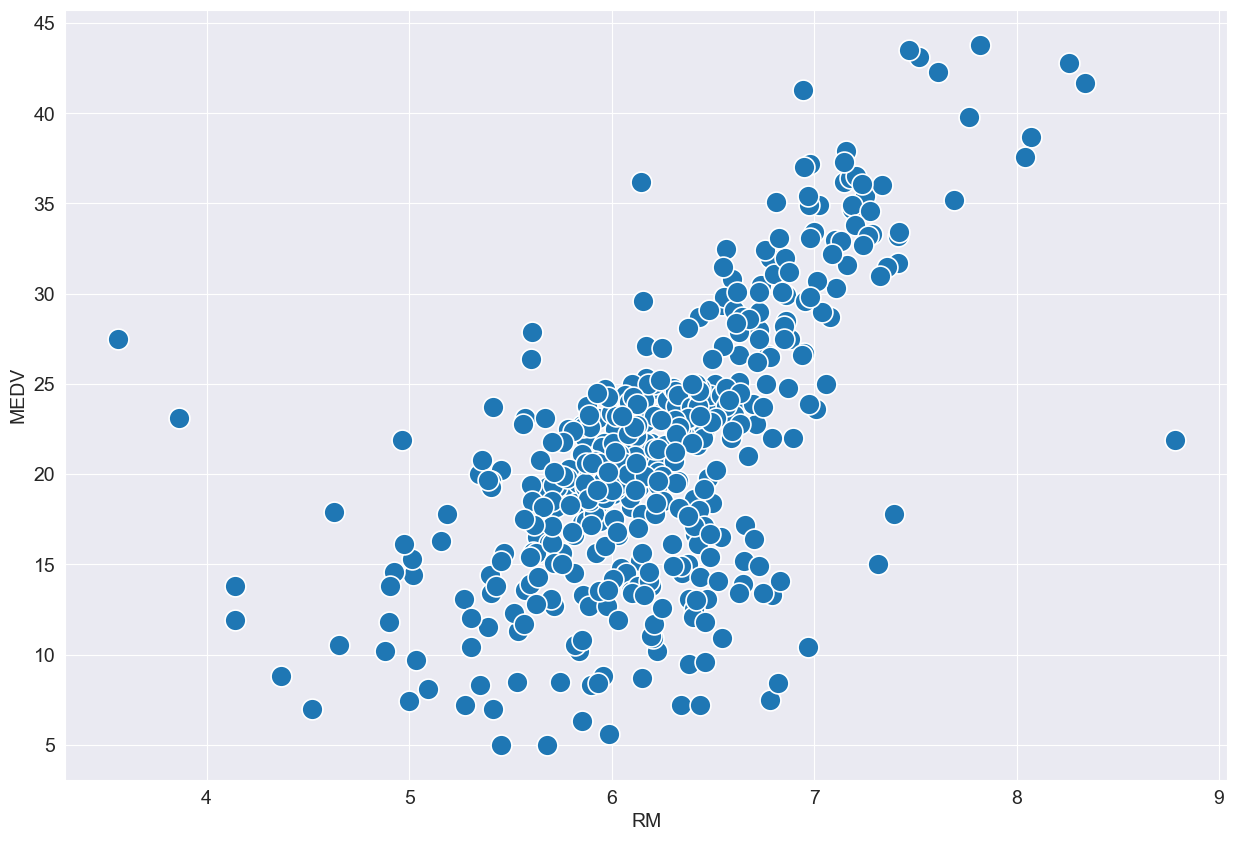

In [25]:
sns.scatterplot(x="RM", y="MEDV", data=df)
plt.show()
#выбивается 50 по у; и меньше 4, больше 8 по х

In [26]:
outliers_1 = df[df["MEDV"] >= 50]
outliers_2 = df[(df["RM"] < 4) | ((df["RM"] > 8) & (df["MEDV"] < 30))]

In [27]:
outliers_1

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV


In [28]:
outliers_2

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
364,3.47428,0.0,18.1,1,0.718,8.780,82.9,1.9047,24,666.0,20.2,354.55,5.29,21.9
365,4.55587,0.0,18.1,0,0.718,3.561,87.9,1.6132,24,666.0,20.2,354.70,7.12,27.5
367,13.52220,0.0,18.1,0,0.631,3.863,100.0,1.5106,24,666.0,20.2,131.42,13.33,23.1


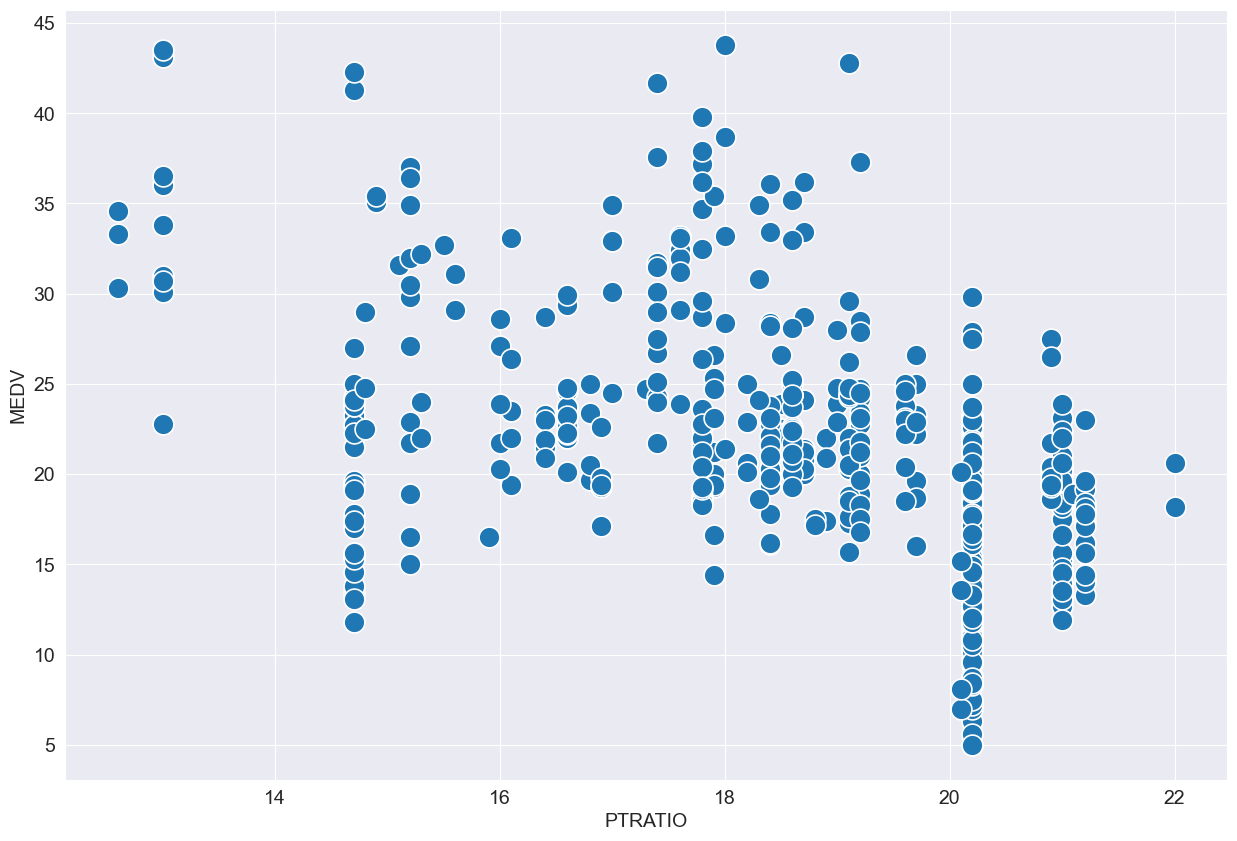

In [29]:
sns.scatterplot(x="PTRATIO", y="MEDV", data=df)
plt.show()
#выьивается больше 44 по у

In [30]:
outliers_4 = df[(df["MEDV"] >= 44)]
outliers_4

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV


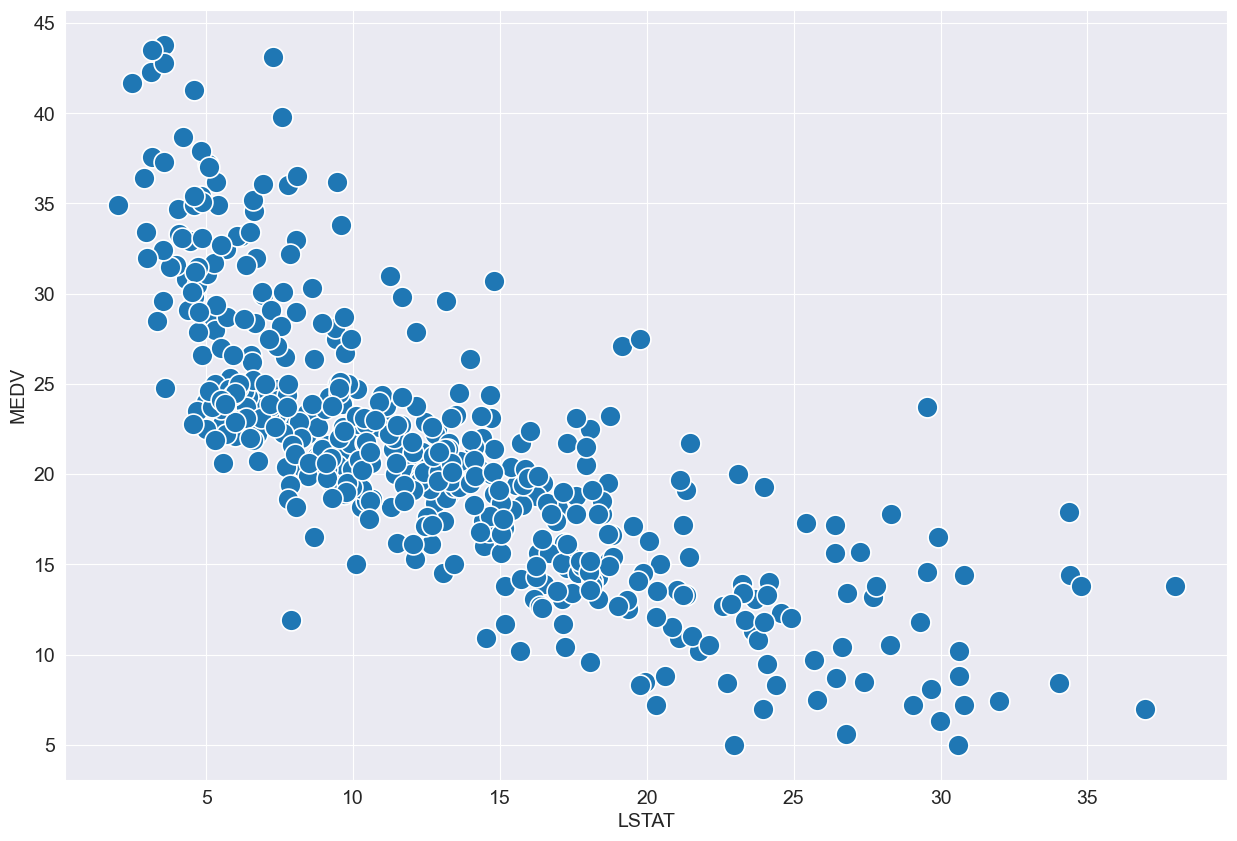

In [31]:
sns.scatterplot(x="LSTAT", y="MEDV", data=df)
plt.show()
#выбивается 50 по у

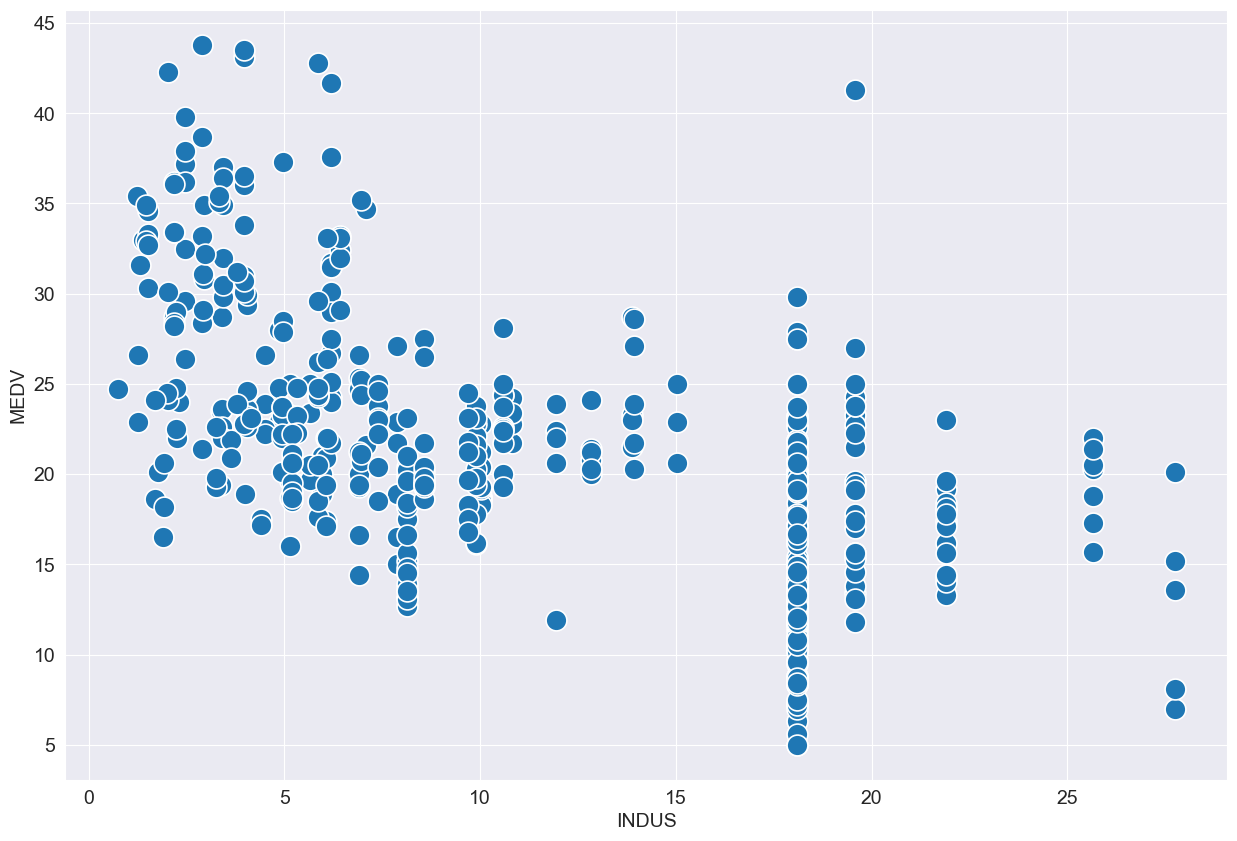

In [32]:
sns.scatterplot(x="INDUS", y="MEDV", data=df)
plt.show()

<p align="center"><img src="https://sun9-72.userapi.com/impg/WgscL25d19mmavnnb2ovW81NTpMZX_o7d4bQ5Q/o8H-xyLmGTM.jpg?size=2000x1391&quality=95&sign=abc3a06040cc7d237b4e0726fe7e22cf&type=album" width=500/></p>